# LASSO analysis

## Setup (using rpy2 to run R code and python in the same notebook)

In [5]:
#### load python packages ####
import os
import pathlib
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, pearsonr, sem, t, norm
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from tqdm import tqdm
import warnings

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm

In [25]:
##### Set a working directory where you want the output CSVs and plots from this analysis to go #####
working_dir = "/Users/josephkelly/Documents/Documents_Primary/Labs/Github/pmc_face/Posteromedial_DevP_FaceProcessing/"
working_dir = os.path.expanduser(working_dir)

#### After running the cell below once, running it again will throw an error because the directories already exist. Don't worry, this is fine!

In [26]:
### This notebook will create a folder called "lasso_output" with folders for CSV files and plots outputted from this notebook
### The folder will be created in the working directory you specified above
csv_path = os.path.join(working_dir, "lasso_output/CSVs")
# plt_path = os.path.join(working_dir, "lasso_output/plots")

os.makedirs(csv_path, exist_ok=True)
# os.makedirs(plt_path, exist_ok=True)

In [27]:
# Set viewing options (# of rows, # of columns, column width) for when you call a python (pandas) dataframe in this notebook
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

### Set up rpy2 and import packages

In [28]:
# For detailed rpy2 instructions, see the documentation: https://rpy2.github.io/doc/latest/html/index.html
# Generally it can be a hassle installing for the first time, but once you have it running it won't give you problems

#### setup rpy2 ####
# run once at start of session
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [29]:
#### import robjects and other necessary packages for rpy2 setup ####
import rpy2.ipython.html
import tzlocal
import rpy2.robjects as robjects
from rpy2.robjects import r

rpy2.ipython.html.init_printing()

In [30]:
# You may need to install the R kernel for jupyter lab if this is your first time using rpy2. If so, try this (you only need to run it once):
# install.packages('IRkernel')
# IRkernel::installspec()

In [31]:
#### import more necessary packages for rpy2 setup ####

# import rpy2's package module
from rpy2.robjects.packages import importr

# import R's utility package
utils = importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # selects the first mirror in the list

<rpy2.rinterface_lib.sexp.NULLType object at 0x170efe140> [RTYPES.NILSXP]

In [32]:
## Check version of R that rpy2 is using 
## (this can be useful to know for troubleshooting, e.g. if the wrong version of R is being used)
robjects.r['version']

0,platform,[1]...
1,arch,"[1] ""x86_64"""
2,os,[1]...
3,system,[1]...
4,status,"[1] """""
5,major,"[1] ""4"""
6,minor,"[1] ""1.3"""
7,year,"[1] ""2022"""
...,...,...
12,version.string,"[1] ""R..."
13,nickname,"[1] ""One..."


In [33]:
## If you need to install certain R packages, use the following syntax (here we're installing 'gridExtra'):
# utils.install_packages('gridExtra')

In [34]:
%%R
# ^if you ever want to run R code with rpy2, you need the "%%R" at the very top of the cell. 

## load your normal R packages ##
library(GGally)
library(tidyverse)
library(ggpubr)
library(repr)
library(ragg)
library(gridExtra)

# Set plot window size
options(repr.plot.width=20, repr.plot.height=8)

# get current working directory
getwd()

[1] "/Users/josephkelly/Documents/Documents_Primary/Labs/Github/pmc_face/Posteromedial_DevP_FaceProcessing"


### LASSO Heatmap and Scatterplot functions

In [35]:
%%R

#### Functions for Plotting Lasso and RMSE ####

# Set the main color for your plots
plt_color = "#D25727"



## plt_lasso function
plt_lasso <- function(df) {
  # make tile plot for lasso coefs
    
  # Pre-filter the data to only include rows within the desired alpha range
#   df <- df[df$alpha_level >= 0.5 & df$alpha_level <= 3.0, ]
  
  lasso_coef_plt <- ggplot(data = df, aes(x=as.factor(alpha_level), y=as.factor(Sulci))) +
    # tile plot
    geom_tile(aes(fill = abs(beta),), size=0.2) +
    
    # set coordinates
    coord_equal() +
    scale_y_discrete(limits = rev(levels(df$Sulci))) +
        
    # set color gradient
    scale_fill_gradient(low = "white", high = "#0072B2")+
    
    
    # set text object and axis labels
    geom_text(aes(label=round(beta, digits = 2), 
                  size = .9), size = 2.7)+
    
    # set axis and legend labels
    xlab("\u03B1-level") +
    ylab('PMC Sulci') +
    labs(fill = "\u03B2 Weights") +
    
    
    # set theme
    theme(
      # set axis title
      axis.title.x = element_text(color="#333333",
                                  size=11),
      axis.text.x = element_text(angle = 40, hjust=1),
      axis.title.y = element_text(color="#333333", 
                                  angle=90,size=11),
      # set axis text
      axis.text = element_text( color='#333333',
                                size = 11),
      # set pannel
      # panel.grid.major = element_blank(),
      # panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      
      # set legend
      legend.title = element_text(color="#333333",size = 11),
      legend.text = element_text( color = '#333333',size = 11),
      
      # set aspect ratio
      aspect.ratio = 10/11
    ) +
    
    theme(panel.background = element_blank())
  
  lasso_coef_plt
}



## plt_Rmse function
plt_rmse <- function(df, show_all_alphas=FALSE) {
  RMSE <- (ggplot(df, aes(x=alpha, y=RMSE)) +
           
             # add smooth line
             geom_smooth( color = "#0072B2" ,
                          span = 0.50,          # This controls how smoothed or "wiggly" your line is
                          se = FALSE, 
                          linewidth = 2,
                          method = "loess") +             
             
             # vertical line to indiciate lowest RMSE at best alpha level
             geom_vline(xintercept = (df$alpha[df$RMSE == min(df$RMSE)]), 
                            linetype="dotted", 
                            size = 1) +

           # axis labels
             # xlab ('log(\u03B1)')+
             xlab('\u03B1') +
             ylab(bquote(RMSE[CV]))+
             
#              scale_x_log10() +
           
             # set theme
             theme_classic() +
             
             # customize theme
             theme(
               # set axis title
               axis.title.x = element_text(color="#333333",
                                           size=12),
               axis.title.y = element_text(color="#333333",
                                           angle=90,size=12),
               # set axis text
               axis.text = element_text( color='#333333',
                                         size = 12 ,hjust =0),
               # set lengend
               legend.text = element_text( color = '#333333',
                                           size = 12),
               # set pannel
               panel.grid.minor=element_blank(),
               legend.title = element_text(color="#333333",
                                           size = 12),
               panel.border = element_rect(colour = "black",
                                           fill=NA, linewidth=1),
               # set aspect ratio
               aspect.ratio = 10/25
             )
  )
  
  if (show_all_alphas==TRUE) {
    
    for (a in df$alpha) {
      RMSE <- RMSE + geom_vline(xintercept = df$alpha[df$alpha == a], 
                                linetype="dotted", 
                                linewidth = 1) +
        annotate(x=a, y=+Inf, label=a, geom="text", hjust=2, vjust=1.3, angle=90, size=3.5) +
        geom_point(color="red")
      
    }
  } else {
      RMSE <- RMSE
  }
    
  RMSE
}


### Analysis functions (LASSO)

In [36]:
## Initialize df that will hold all the dataframes from lasso analyses
lasso_df_dict = {}
# initialize leave-one-out cross-validation (LOOCV)
loo = LeaveOneOut()

### Analysis functions (fully nested LASSO)

In [37]:
def lasso_fully_nested(Xr, yr, alpha_vals, n_folds = loo):
    '''
        NOTE: This is the only function you need to run the fully nested LASSO.
            The lasso_analysis_fully_nested function below is just for making output files, 
            which become necessary for plotting.    
    '''

    Xtests = []
    ytests = []
    ypreds = []
    best_alphas = []
    best_rmses = []
    best_coefs = []
    best_grid_features = []
    best_models = []
    sulc_beta_dicts = []
    results_dfs = []
    fold_ct = []
    
    X_array = np.array(Xr) # set input arrays as np objects
    y_array = np.array(yr)

    # split into train and test
    no_feats = False
    fold = 1

    for train_idx, test_idx in loo.split(Xr):
        X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
        y_train, y_test = y_array[train_idx], y_array[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train = X_train_scaled
        X_test = X_test_scaled
        
        # determine the alpha-value that minimizes RMSE with GridSearchCV.
        lasso = Lasso(max_iter=10000)
        lasso_regressor = GridSearchCV(lasso, alpha_vals, scoring = 'neg_root_mean_squared_error', cv = n_folds, n_jobs=4)
        lasso_regressor.fit(X_train,y_train)
        
        # retrieve best model parameters from the grid search with corresponding RRMSE
        best_grid_alpha = lasso_regressor.best_params_
        best_grid_RMSE = lasso_regressor.best_score_ * -1  # sklearn makes RMSE values negative because all its modules automatically select the "best" model as the one with the highest score, so we have to multipy by -1
        best_model = lasso_regressor.best_estimator_    # best model
        results_df = lasso_regressor.cv_results_

        # fit the best model
        best_model = lasso_regressor.best_estimator_
        best_model.fit(X_train,y_train)
        y_pred = best_model.predict(X_test)
                        
        # Create dict of selected features with coefficients
        non_zero_coefs = best_model.coef_ != 0
        selected_features = Xr.columns[non_zero_coefs].tolist()        
        lasso_slct_coefs = [i for i in best_model.coef_ if i !=0]
        sulc_beta_dict = {key: value for key, value in zip(selected_features, lasso_slct_coefs)}
        
        Xtests += list(X_test)
        ytests += list(y_test)
        ypreds += list(y_pred)
        best_alphas.append(best_grid_alpha['alpha'])
        best_rmses.append(best_grid_RMSE)
        best_coefs.append(list(best_model.coef_))
        best_grid_features.append(selected_features)
        best_models.append(best_model)
        sulc_beta_dicts.append(sulc_beta_dict)
        results_dfs.append(results_df)
        fold_ct.append(round(len(set(best_rmses))))
        
        fold += 1

    # Calculate model performance metrics    
    rr = r2_score(ytests, ypreds)
#     ms_error = mean_squared_error(ytests, ypreds, squared=True)  # MSE
    rmse = mean_squared_error(ytests, ypreds, squared=False)  # RMSE

    # save predicted/measured scores as a dataframe (and write to csv)
    model_preds = pd.DataFrame({"Xtest": Xtests, "Measured": ytests, "Predicted": ypreds})
    model_preds_corr = model_preds.loc[:, "Measured":]
    model_preds_corr = model_preds_corr.explode('Measured')
        
    # output dict with all the stats you want
    return {"fold_ct": fold_ct,
            "best_alphas": best_alphas, 
            "best_rmses": best_rmses, 
            "best_coefs": best_coefs, 
            "best_grid_features": selected_features,
            "best_models": best_models,
            "sulc_beta_dicts": sulc_beta_dicts,
            "cv_results_dfs": results_dfs,
            "final_rr": rr,
            "final_rmse": rmse,
            "final_model_preds_df": model_preds_corr
           }

In [38]:
def lasso_analysis_fully_nested(file_label, sulc_df, X_inds, y_dep, alphas, model_name):
    '''
    Takes file label name (in order to name final csv files), a dataframe of sulcal metrics, 
    lists of the predictor sulci and the target metric, and a dictionary with a list of the alpha values to try. 
    Runs Lasso analysis function (called "lasso_reg" above) and returns three dataframes: 
    (1) Dataframe with beta coefs for each predictor at each alpha value. Also reports rmse of model.
    (2) Dataframe with only beta coefs and alpha values.
    (3) Dataframe with only rmse for each alpha value.
    '''
    
    lasso_df = pd.DataFrame({
        'alpha_level': [],
        'fold':[],
        'RMSE': [],
        'Sulci': [],
        'beta': [],
        'Model': []
        })

    # for each alpha value in "alphas" run the LASSO analysis
    for i in tqdm(alphas.get('alpha', 999)):
        alpha_dict = {'alpha': [i]}

        lasso_analysis_func = lasso_fully_nested(sulc_df[X_inds], sulc_df[y_dep], alpha_dict)
        
        fold_ct = lasso_analysis_func["fold_ct"]
        coefs_val = lasso_analysis_func["best_coefs"]
        rmse_val = lasso_analysis_func["best_rmses"]
        alpha_val = lasso_analysis_func["best_alphas"][0]
        best_model = lasso_analysis_func["best_models"]
        sulc_beta_dict = lasso_analysis_func["sulc_beta_dicts"]

        num_betas = len([i for sublist in lasso_analysis_func["best_coefs"] for i in sublist])
        num_sulc = len(X_inds)
        
        lasso_alpha_df = pd.DataFrame({
        'fold': [item for item in lasso_analysis_func["fold_ct"] for _ in range(num_sulc)], 
        'Sulci': X_inds * int(num_betas / num_sulc),
        'alpha_level': [item for item in lasso_analysis_func["best_alphas"] for _ in range(num_sulc)],
        'beta': [i for sublist in lasso_analysis_func["best_coefs"] for i in sublist],
        'RMSE': [item for item in lasso_analysis_func["best_rmses"] for _ in range(num_sulc)],
        'Model': [item for item in lasso_analysis_func["best_models"] for _ in range(num_sulc)]
        })

        lasso_df = pd.concat([lasso_df, lasso_alpha_df])
        
        
    lasso_df = lasso_df.reset_index(drop=True)    
    lasso_coefs = lasso_df.loc[:, 'Sulci':'beta']
    lasso_rmse = lasso_df[['alpha_level', 'RMSE']].copy()
    lasso_rmse = lasso_rmse.rename(columns = {'alpha_level':'alpha'})
    lasso_rmse = lasso_rmse.drop_duplicates().reset_index(drop=True)
    
    lasso_df_dict[file_label + '_all_lasso_df'] = lasso_df
    lasso_df_dict[file_label + '_coefs_lasso_df'] = lasso_coefs
    lasso_df_dict[file_label + '_rmse_lasso_df'] = lasso_rmse
    
    lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", file_label + '_all_lasso_df.csv'), index=False)
    lasso_coefs.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", file_label + '_coefs_lasso_df.csv'), index=False)
    lasso_rmse.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", file_label + '_rmse_lasso_df.csv'), index=False)
    
    # return the output dictionary from lasso function
    return lasso_df_dict

In [39]:
def calculate_aic(n, rmse, num_params):
    '''
    Calculates AIC corrected for small sample size, and adapted to linear regression, per Burnham and Anderson 2002.
    input:
    - n = num observations
    - rmse = mean squared error from regression
    - num_params = number of predictors in the model (including the intercept if applicable!)
    '''
    K = num_params
    
    mse = rmse ** 2
    
    aic = n * np.log(mse) + 2 * K

    aic_c = aic + (2*K*(K+1))/(n - K - 1)

    return aic_c

In [40]:
def linreg_cv(Xr, yr):
    '''
    Linear regression with leave-one-out cross-validation.
    ''' 
    Xtests = []
    ytests = []
    ypreds = []
    
    # set input arrays as np objects
    X_array = np.array(Xr)
    y_array = np.array(yr)
    
    # split into train and test
    for train_idx, test_idx in loo.split(Xr):
        X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
        y_train, y_test = y_array[train_idx], y_array[test_idx]

        # fit model on training data and predict
        lm = LinearRegression()
        model = lm.fit(X_train, y_train)
        y_pred = lm.predict(X_test)

        Xtests += list(X_test)
        ytests += list(y_test)
        ypreds += list(y_pred)

    rr = r2_score(ytests, ypreds)
    rms_error = mean_squared_error(ytests, ypreds, squared = False)
    model_preds = pd.DataFrame({"Xtest": Xtests, "Measured": ytests, "Predicted": ypreds})
        
    linreg_results = {
        'rsquared': rr,
        'rmse': rms_error,
        'preds_df': model_preds
    }

    return linreg_results

## Data Import and Processing

In [41]:
### Paths to sulc_morphology CSV and behavioral CSV.
sulc_df_path = working_dir + "data/dp_depth_2024_04_25.csv"
# sulc_df_path = working_dir + "data/dp_thick_2024_04_25.csv"

morph_df = pd.read_csv(sulc_df_path)

morph_name = 'depth'
# morph_name = 'thick'  # if you're looking at thickness, for example, simply change the morph_name accordingly

# Specify column name for the behavioral variable of interest
beh_var1 = 'CFMT'

# Easily identifiable names of morphological metric and behavioral metric for sake of naming files
beh_name1 = "CFMT"

morph_df = morph_df.loc[:, ~morph_df.columns.isin(["Unnamed: 0", "grp_hemi", "pmc_p", "pmc_pX", 
                                                   "pmc_pY", "pmc_pXY", "sbps_a", "sbps_p"])]
cols_to_edit = ['prculs_d', 'prcus_p', 'prcus_i', 'prcus_a', 'sspls_v', 'sspls_d', 'icgs_p', 'prculs_v']
morph_df.rename(columns={col: col.replace('_', '-') for col in cols_to_edit}, inplace=True)

morph_df.head()

,sub,group,hemi,Age,Sex,CFMT,PC1,PC2,PC3,Famous_Faces_UKidentified,WASIIQ_full,CHMT,Cars,Baldwomen,Horses,Famous_Faces_UKexposed,Eyes_Testratio,Eyes_Testemotion,CFPTup,CFPTinv,Films_taskup,Sequential_idup,Sequential_em_inv,Sequential_emup,Sequential_id_inv,WASIIQ_verbal,WASIIQ_performance,mcgs,pos,prculs-d,prcus-a,prcus-i,prcus-p,sbps,prculs-v,sspls-v,ifrms,icgs-p,sspls-d
0,1,Controls,lh,49,1,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339250,0.461265,0.260861,-0.119291,0.175656,-0.052681,0.247375,-0.043685,-0.114395,-0.030633,NaN,NaN
1,1,Controls,rh,49,1,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333059,0.403976,0.241664,0.206043,-0.019838,0.016329,0.214070,-0.244604,NaN,-0.033712,-0.068228,NaN
2,2,DPs,lh,61,1,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.336948,0.386897,0.052703,0.085642,0.256779,-0.037750,0.182881,NaN,-0.064678,-0.088681,-0.113125,-0.069261
3,2,DPs,rh,61,1,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.262253,0.328628,0.080397,0.141360,0.059672,0.055783,0.238574,NaN,NaN,-0.066402,-0.108539,0.007154
4,3,Controls,lh,52,0,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.295693,0.399121,0.189372,0.260846,0.143805,0.131191,0.301859,NaN,NaN,0.059896,NaN,NaN


In [42]:
sulc_list = ['mcgs', 'pos', 'sbps', 'prculs-d', 'prcus-p', 'prcus-i', 'prcus-a', 'ifrms', 'sspls-v']

# group_name = "Controls"

# Create dataframes for analysis
subset_cfmt_df = morph_df[['sub', 'group', 'hemi', 'CFMT'] + sulc_list].dropna()
cfmt_RH_df = subset_cfmt_df[(subset_cfmt_df['hemi'] == 'rh') & (subset_cfmt_df['group'] == 'Controls')] 
cfmt_LH_df = subset_cfmt_df[(subset_cfmt_df['hemi'] == 'lh') & (subset_cfmt_df['group'] == 'Controls')]
# cfmt_RH_df = subset_cfmt_df[(subset_cfmt_df['hemi'] == 'rh') & (subset_cfmt_df['group'] == 'DPs')] 
# cfmt_LH_df = subset_cfmt_df[(subset_cfmt_df['hemi'] == 'lh') & (subset_cfmt_df['group'] == 'DPs')]

In [43]:
morph_name = 'depth'   # Specify which metric we'll use (for file naming)
# morph_name = 'thick'

# Specify dataframes for LASSO
beh_var = 'CFMT'
lasso_RH_df = cfmt_RH_df
lasso_LH_df = cfmt_LH_df

# Names of files that will hold LASSO results
LH_filename = morph_name + '_LH_' + beh_var
RH_filename = morph_name + '_RH_' + beh_var

### List of alpha values to try for each dataset
# for a comprehensive initial list, choose test_list. Then narrow down from there for plotting purposes
# test_list = [round(num, 3) for num in (np.logspace(-2, -.5, 5).tolist() + np.linspace(.5, 4, 72).tolist() + np.logspace(0.65, 1, 5).tolist())]

# # more constrained list
# alpha_list_RH = [round(num, 3) for num in np.linspace(1.3, 1.4, 21).tolist()]  # depth
# alpha_list_LH = [round(num, 3) for num in np.linspace(0.5, 2.5, 11).tolist()]  # depth

# more constrained list
alpha_list_RH = [round(num, 3) for num in np.logspace(-1, 1, 70).tolist()]  # depth
alpha_list_LH = [round(num, 3) for num in np.logspace(-1, 1, 70).tolist()]  # depth




# ==================================================
RH_alphas = {'alpha': alpha_list_RH}  
LH_alphas = {'alpha': alpha_list_LH} 

# LASSO (fully nested)

In [44]:
#### RUN LASSO and get all beta coefficients ####

### For each LASSO: 
# List the file label, dataframe you want to use, list of sulcal predictors, and dictionary with the alpha values
file_labels = [
    (RH_filename, lasso_RH_df, sulc_list, RH_alphas),
    (LH_filename, lasso_LH_df, sulc_list, LH_alphas),
]
# Run again but recording each beta weight for each alpha value. This is for plotting purposes
for label, data, X_sulc, alphas in file_labels:
    print("Size of sample (# of hemispheres): {}".format(data.shape[0]))  # tells you how many hemispheres are in your sample
    print()
    print("Alpha values: {}".format(alphas))
    print()
    print("Predictors: {}".format(X_sulc))
    print()
    print(label)
    print("Here's the data you're working with:")
    display(HTML(data.head().to_html()))
    print()
    print("================================================================")
    print("RESULTS:")
    print("================================================================")
    print()
    lasso_analysis_fully_nested(file_label = label,
#     lasso_analysis(file_label = label,
                        sulc_df = data,
                        X_inds = X_sulc,
                        y_dep = beh_var,
                        alphas = alphas,
                        model_name = label)
    print()
    print()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print()
    print()

Size of sample (# of hemispheres): 28

Alpha values: {'alpha': [0.1, 0.107, 0.114, 0.122, 0.131, 0.14, 0.149, 0.16, 0.171, 0.182, 0.195, 0.208, 0.223, 0.238, 0.255, 0.272, 0.291, 0.311, 0.332, 0.355, 0.38, 0.406, 0.434, 0.464, 0.496, 0.53, 0.567, 0.606, 0.648, 0.693, 0.741, 0.792, 0.846, 0.905, 0.967, 1.034, 1.105, 1.182, 1.263, 1.35, 1.444, 1.543, 1.65, 1.764, 1.885, 2.015, 2.154, 2.303, 2.462, 2.632, 2.814, 3.008, 3.215, 3.437, 3.675, 3.928, 4.199, 4.489, 4.799, 5.13, 5.484, 5.863, 6.268, 6.7, 7.163, 7.657, 8.185, 8.75, 9.354, 10.0]}

Predictors: ['mcgs', 'pos', 'sbps', 'prculs-d', 'prcus-p', 'prcus-i', 'prcus-a', 'ifrms', 'sspls-v']

depth_RH_CFMT
Here's the data you're working with:


,sub,group,hemi,CFMT,mcgs,pos,sbps,prculs-d,prcus-p,prcus-i,prcus-a,ifrms,sspls-v
9,5,Controls,rh,57,0.230325,0.358725,0.246424,0.132252,0.097618,0.237201,0.066041,0.044888,-0.079673
15,9,Controls,rh,55,0.284488,0.312909,0.142784,0.006037,-0.094094,0.197304,0.141086,0.024553,-0.184593
17,10,Controls,rh,55,0.178530,0.309140,0.356702,0.131647,0.170744,0.067373,0.053883,0.053770,-0.023848
21,12,Controls,rh,70,0.322996,0.301914,0.196433,0.108942,-0.184805,0.029729,0.182820,-0.134193,-0.129211
23,13,Controls,rh,64,0.306576,0.285416,0.189249,0.165366,-0.122162,0.235318,0.259331,-0.075918,-0.134468



RESULTS:



100%|█████████████████████████████████████████████████████████████| 70/70 [00:23<00:00,  2.95it/s]




>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


Size of sample (# of hemispheres): 35

Alpha values: {'alpha': [0.1, 0.107, 0.114, 0.122, 0.131, 0.14, 0.149, 0.16, 0.171, 0.182, 0.195, 0.208, 0.223, 0.238, 0.255, 0.272, 0.291, 0.311, 0.332, 0.355, 0.38, 0.406, 0.434, 0.464, 0.496, 0.53, 0.567, 0.606, 0.648, 0.693, 0.741, 0.792, 0.846, 0.905, 0.967, 1.034, 1.105, 1.182, 1.263, 1.35, 1.444, 1.543, 1.65, 1.764, 1.885, 2.015, 2.154, 2.303, 2.462, 2.632, 2.814, 3.008, 3.215, 3.437, 3.675, 3.928, 4.199, 4.489, 4.799, 5.13, 5.484, 5.863, 6.268, 6.7, 7.163, 7.657, 8.185, 8.75, 9.354, 10.0]}

Predictors: ['mcgs', 'pos', 'sbps', 'prculs-d', 'prcus-p', 'prcus-i', 'prcus-a', 'ifrms', 'sspls-v']

depth_LH_CFMT
Here's the data you're working with:


,sub,group,hemi,CFMT,mcgs,pos,sbps,prculs-d,prcus-p,prcus-i,prcus-a,ifrms,sspls-v
0,1,Controls,lh,60,0.339250,0.461265,0.247375,0.260861,-0.052681,0.175656,-0.119291,-0.030633,-0.114395
8,5,Controls,lh,57,0.267446,0.390333,0.333811,0.168618,-0.008642,-0.022252,0.209611,0.011798,-0.118254
14,9,Controls,lh,55,0.315471,0.333516,0.190406,0.063624,-0.174217,0.232452,-0.074239,0.017188,-0.165045
16,10,Controls,lh,55,0.264816,0.367201,0.242217,0.134332,-0.208611,0.152142,0.196902,-0.037295,-0.010556
18,11,Controls,lh,55,0.330563,0.369866,0.322942,0.143868,-0.036113,0.004892,0.001199,-0.121232,-0.110313



RESULTS:



100%|█████████████████████████████████████████████████████████████| 70/70 [00:36<00:00,  1.94it/s]




>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>




In [45]:
#### Import lasso csv files for plotting and calculate median betas and MSE's from all folds ####
RH_rmse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_rmse_lasso_df.csv")
RH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_all_lasso_df.csv")
LH_rmse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_rmse_lasso_df.csv")
LH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_all_lasso_df.csv")

# Calculate median values for beta coefficients and MSE
median_betas_RH = RH_all_lasso_df.groupby(['alpha_level', 'Sulci'])['beta'].median().reset_index()
median_RMSE_RH = RH_all_lasso_df.groupby('alpha_level')['RMSE'].median().reset_index()
median_betas_LH = LH_all_lasso_df.groupby(['alpha_level', 'Sulci'])['beta'].median().reset_index()
median_RMSE_LH = LH_all_lasso_df.groupby('alpha_level')['RMSE'].median().reset_index()
# Merge the two 'all' dataframes on 'alpha_level'
RH_all_lasso_df = pd.merge(median_betas_RH, median_RMSE_RH, on='alpha_level', how='left')
LH_all_lasso_df = pd.merge(median_betas_LH, median_RMSE_LH, on='alpha_level', how='left')

# # Group mse df by alpha value
# RH_rmse_lasso_df = RH_rmse_lasso_df.groupby('alpha')['RMSE'].median().reset_index()
# LH_rmse_lasso_df = LH_rmse_lasso_df.groupby('alpha')['RMSE'].median().reset_index()
RH_rmse_lasso_df = median_RMSE_RH.rename(columns={'alpha_level': 'alpha'})
LH_rmse_lasso_df = median_RMSE_LH.rename(columns={'alpha_level': 'alpha'})

RH_all_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", RH_filename + '_all_lasso_df_median.csv'), index=False)
LH_all_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", LH_filename + '_all_lasso_df_median.csv'), index=False)
RH_rmse_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", RH_filename + '_rmse_lasso_df_median.csv'), index=False)
LH_rmse_lasso_df.to_csv(os.path.join(working_dir, "lasso_output/CSVs/fully_nested/", LH_filename + '_rmse_lasso_df_median.csv'), index=False)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


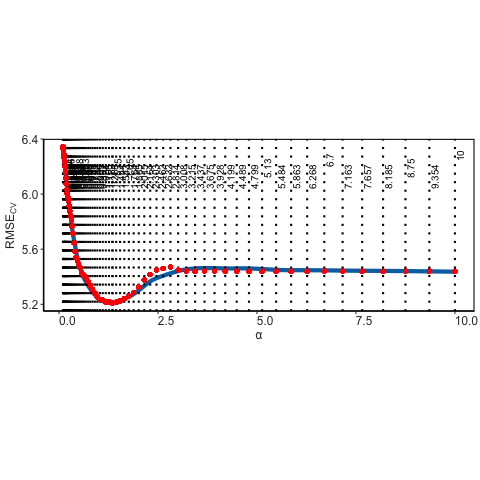

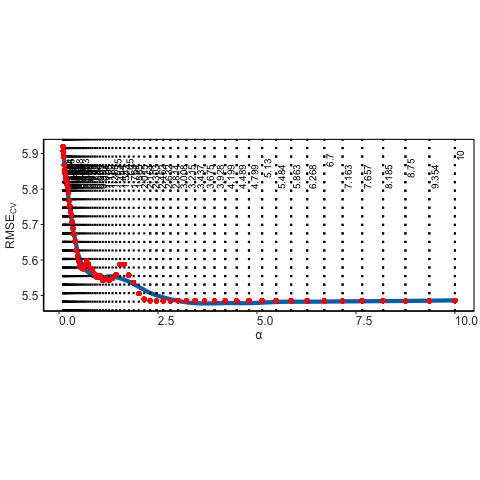

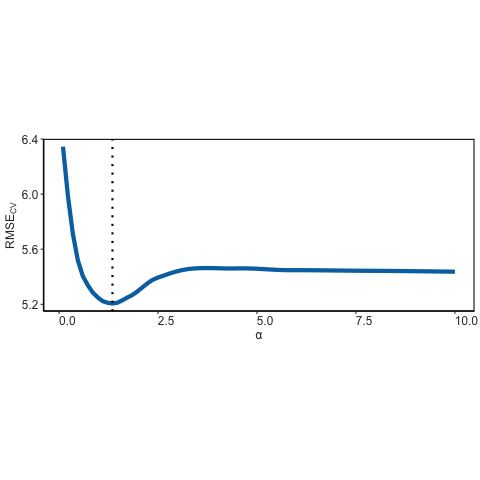

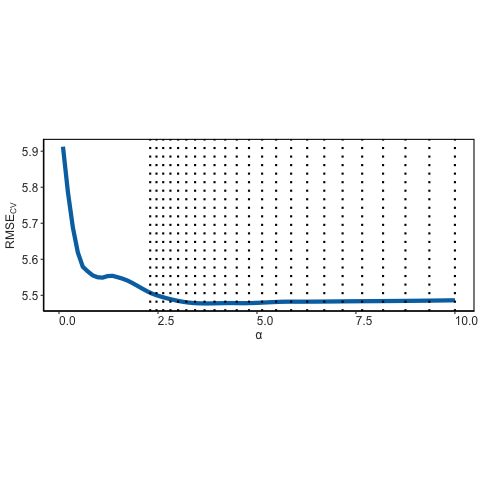

In [46]:
%%R -i RH_rmse_lasso_df,LH_rmse_lasso_df

# using optional arg "TRUE" is for diagnostics. "FALSE" will give you a clean plot
print(plt_rmse(RH_rmse_lasso_df, show_all_alphas=TRUE))
print(plt_rmse(LH_rmse_lasso_df, show_all_alphas=TRUE))

# clean version of plots
print(plt_rmse(RH_rmse_lasso_df, show_all_alphas=FALSE))
print(plt_rmse(LH_rmse_lasso_df, show_all_alphas=FALSE))

In [47]:
#### Import lasso csv files for plotting ####
RH_rmse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_rmse_lasso_df_median.csv")
RH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + RH_filename + "_all_lasso_df_median.csv")
LH_rmse_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_rmse_lasso_df_median.csv")
LH_all_lasso_df = pd.read_csv(working_dir + "lasso_output/CSVs/fully_nested/" + LH_filename + "_all_lasso_df_median.csv")

### Plot LASSO Results

In [48]:
alpha_min_RH = RH_rmse_lasso_df[RH_rmse_lasso_df['RMSE'] == min(RH_rmse_lasso_df['RMSE'])]['alpha']
alpha_min_LH = LH_rmse_lasso_df[LH_rmse_lasso_df['RMSE'] == min(LH_rmse_lasso_df['RMSE'])]['alpha']

alpha_list_RH_forPlot = [round(num, 2) for num in alpha_list_RH[24:60][::3][:10]]
alpha_list_LH_forPlot = [round(num, 2) for num in alpha_list_RH[24:60][::3][:10]]

alpha_list_RH_forPlot

[0.5, 0.61, 0.74, 0.91, 1.1, 1.35, 1.65, 2.02, 2.46, 3.01]

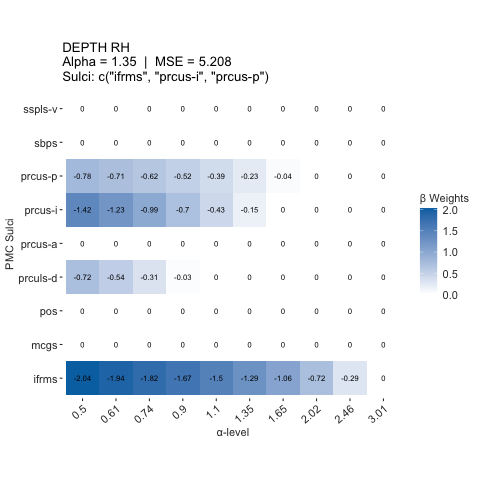

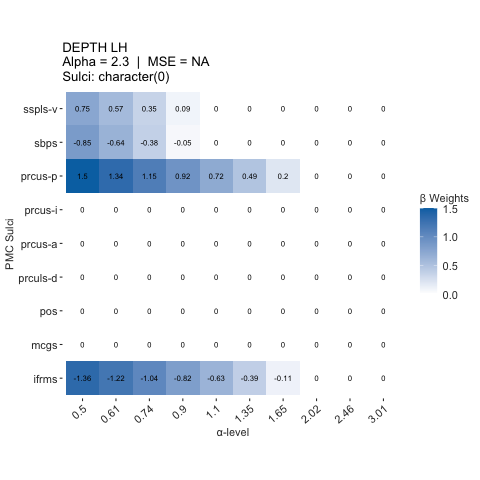

In [49]:
%%R -i RH_rmse_lasso_df,RH_all_lasso_df,LH_rmse_lasso_df,LH_all_lasso_df,alpha_list_RH_forPlot,alpha_list_LH_forPlot -o alpha_min_RH,alpha_min_LH

#### Plot all LASSO and RMSE results ####

## ALPHA ROUNDING BLOCK - COMMENT OUT TO DISABLE ##
# Round all alpha values to 2 decimal places
RH_all_lasso_df$alpha_level <- round(RH_all_lasso_df$alpha_level, 2)
LH_all_lasso_df$alpha_level <- round(LH_all_lasso_df$alpha_level, 2)
# For RMSE dataframes
RH_rmse_lasso_df$alpha <- round(RH_rmse_lasso_df$alpha, 2)
LH_rmse_lasso_df$alpha <- round(LH_rmse_lasso_df$alpha, 2)

# Filter to only include alpha values from the specified list
filtered_alphas <- unique(round(RH_all_lasso_df$alpha_level, 2))[seq(24, 60, 3)][1:10]
RH_all_lasso_df <- RH_all_lasso_df %>% filter(alpha_level %in% filtered_alphas)
LH_all_lasso_df <- LH_all_lasso_df %>% filter(alpha_level %in% filtered_alphas)
## END ALPHA ROUNDING BLOCK ##

# RH NT
alpha_min_RH = RH_rmse_lasso_df$alpha[RH_rmse_lasso_df$RMSE == min(RH_rmse_lasso_df$RMSE)]
mse_val_RH = RH_all_lasso_df$RMSE[RH_all_lasso_df$alpha_level == alpha_min_RH]
sulci_RH = RH_all_lasso_df %>% filter((alpha_level == alpha_min_RH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(RH_all_lasso_df) + 
     ggtitle(paste0(
    "DEPTH RH
Alpha = ", as.character(round(alpha_min_RH, 2)), "  |  MSE = ", as.character(round(mse_val_RH[1], 3)), "
Sulci: ", as.character(sulci_RH)
            )))

# LH NT
alpha_min_LH = LH_rmse_lasso_df$alpha[LH_rmse_lasso_df$RMSE == min(LH_rmse_lasso_df$RMSE)]
mse_val_LH = LH_all_lasso_df$RMSE[LH_all_lasso_df$alpha_level == alpha_min_LH]
sulci_LH = LH_all_lasso_df %>% filter((alpha_level == alpha_min_LH) & (abs(beta) > 0)) %>% select(Sulci)
plot(plt_lasso(LH_all_lasso_df) + 
     ggtitle(paste0(
    "DEPTH LH
Alpha = ", as.character(round(alpha_min_LH, 2)), "  |  MSE = ", as.character(round(mse_val_LH[1], 3)), "
Sulci: ", as.character(sulci_LH)
            )))

## Full Model Summary and Evaluation

In [50]:
# Running model again to confirm, 
# can use alpha_min_RH and alpha_min_LH lines to just use the optimal alpha and speed things up

alpha_dict_vf_RH = {'alpha': [alpha_min_RH[0]]}
alpha_dict_vf_LH = {'alpha': [alpha_min_LH[0]]}

results_dict_rh = lasso_fully_nested(lasso_RH_df[X_sulc], lasso_RH_df[beh_var], alpha_dict_vf_RH)
results_dict_lh = lasso_fully_nested(lasso_LH_df[X_sulc], lasso_LH_df[beh_var], alpha_dict_vf_LH)

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have data for both hemispheres
df_RH = pd.DataFrame(results_dict_rh['sulc_beta_dicts'])
df_LH = pd.DataFrame(results_dict_lh['sulc_beta_dicts'])

# Add Hemisphere column to differentiate the data
df_RH['Hemisphere'] = 'RH'
df_LH['Hemisphere'] = 'LH'
df_combined = pd.concat([df_RH, df_LH], ignore_index=True)

# Calculate counts and percentages separately for each hemisphere
sulcus_counts_RH = df_RH.drop(columns='Hemisphere').count()
sulcus_counts_LH = df_LH.drop(columns='Hemisphere').count()
total_dicts_RH = len(df_RH)
total_dicts_LH = len(df_LH)
sulcus_percentage_RH = (sulcus_counts_RH / total_dicts_RH) * 100
sulcus_percentage_LH = (sulcus_counts_LH / total_dicts_LH) * 100

# Create DataFrames for each hemisphere's statistics
sulcus_stats_RH = pd.DataFrame({
    'Sulcus': sulcus_counts_RH.index,
    'Count': sulcus_counts_RH.values,
    'Percentage': sulcus_percentage_RH.values,
    'Hemisphere': 'RH'
})
sulcus_stats_LH = pd.DataFrame({
    'Sulcus': sulcus_counts_LH.index,
    'Count': sulcus_counts_LH.values,
    'Percentage': sulcus_percentage_LH.values,
    'Hemisphere': 'LH'
})

print("Sulcus Statistics for RH:")
print(sulcus_stats_RH)
print()
print("Sulcus Statistics for LH:")
print(sulcus_stats_LH)
print()

# Melt the combined DataFrame for easier plotting
df_melted = df_combined.melt(id_vars='Hemisphere', var_name='Sulcus', value_name='Beta')

# Calculate and print medians for each hemisphere separately (ONLY FOR SULCI SELECTED >50% OF THE TIME)
df_RH_numeric = df_RH.select_dtypes(include=[np.number])
df_LH_numeric = df_LH.select_dtypes(include=[np.number])
medians_RH = df_RH_numeric.loc[:, df_RH_numeric.count() > total_dicts_RH / 2].median().round(2)
medians_LH = df_LH_numeric.loc[:, df_LH_numeric.count() > total_dicts_LH / 2].median().round(2)

print()
print()
print()

print("Medians for each Sulcus in the Right Hemisphere:")
print(medians_RH)
print()
print("Medians for each Sulcus in the Left Hemisphere:")
print(medians_LH)

Sulcus Statistics for RH:
    Sulcus  Count  Percentage Hemisphere
0  prcus-p     25   89.285714         RH
1  prcus-i     22   78.571429         RH
2    ifrms     28  100.000000         RH
3     mcgs      1    3.571429         RH
4      pos      1    3.571429         RH

Sulcus Statistics for LH:
Empty DataFrame
Columns: [Sulcus, Count, Percentage, Hemisphere]
Index: []




Medians for each Sulcus in the Right Hemisphere:
prcus-p   -0.26
prcus-i   -0.17
ifrms     -1.29
dtype: float64

Medians for each Sulcus in the Left Hemisphere:
Series([], dtype: float64)


In [52]:
# trim off extreme alpha values (as determined by rmse plots above) so that bootstrapping runs faster
alpha_dict_vf_RH = {'alpha': [round(num, 3) for num in np.logspace(-1, 1, 70).tolist()][14:58]}
alpha_dict_vf_LH = {'alpha': [round(num, 3) for num in np.logspace(-1, 1, 70).tolist()][14:58]}

### Warning: Bootstrapping can take many hours, depending on your machine's specs

In [37]:
# Initialize data structures
sulcus_counts_RH = {sulc: 0 for sulc in X_sulc}
sulcus_counts_LH = {sulc: 0 for sulc in X_sulc}
sulcus_coeffs_RH = {sulc: [] for sulc in X_sulc}  # Store coefficients for each sulcus
sulcus_coeffs_LH = {sulc: [] for sulc in X_sulc}

# Number of bootstrap iterations
n_bootstrap = 2000

# Bootstrap iterations with tqdm progress bar
for i in tqdm(range(n_bootstrap), desc="Bootstrapping iterations"):
    # Resample the data
    lasso_RH_resample = lasso_RH_df.sample(frac=1, replace=True)
    lasso_LH_resample = lasso_LH_df.sample(frac=1, replace=True)

    # Perform LASSO with fully nested cross-validation
    results_dict_rh = lasso_fully_nested(lasso_RH_resample[X_sulc], lasso_RH_resample[beh_var], alpha_dict_vf_RH)
    results_dict_lh = lasso_fully_nested(lasso_LH_resample[X_sulc], lasso_LH_resample[beh_var], alpha_dict_vf_LH)

    # Retrieve sulc_beta_dicts (list of dictionaries for LOO folds)
    beta_dict_list_rh = results_dict_rh['sulc_beta_dicts']
    beta_dict_list_lh = results_dict_lh['sulc_beta_dicts']

    # Update counts and collect coefficients
    for sulc in X_sulc:
        sulcus_counts_RH[sulc] += sum(1 for beta_dict in beta_dict_list_rh if sulc in beta_dict)
        sulcus_counts_LH[sulc] += sum(1 for beta_dict in beta_dict_list_lh if sulc in beta_dict)

        # Collect coefficients when the sulcus is selected
        sulcus_coeffs_RH[sulc].extend([beta_dict[sulc] for beta_dict in beta_dict_list_rh if sulc in beta_dict])
        sulcus_coeffs_LH[sulc].extend([beta_dict[sulc] for beta_dict in beta_dict_list_lh if sulc in beta_dict])

Bootstrapping iterations: 100%|█████████████████████████████| 2000/2000 [9:26:10<00:00, 16.99s/it]


Final Sulcus Statistics for Right Hemisphere:
          Avg Count  Percentage  Median Coeff  95% CI Lower  95% CI Upper
ifrms         24.21       86.45         -1.76         -4.41         -0.22
prcus-i       17.16       61.28         -1.85         -5.27         -0.15
prcus-p       15.74       56.21         -1.26         -4.41         -0.03
prculs-d      14.94       53.36         -1.23         -3.89          1.86
pos           13.61       48.59         -0.51         -2.91          2.26
sspls-v       12.15       43.39          0.04         -1.97          2.86
sbps          11.57       41.31         -0.47         -3.14          3.11
prcus-a        9.78       34.94         -0.78         -4.00          2.45
mcgs           9.58       34.22          0.14         -2.95          1.89

Final Sulcus Statistics for Left Hemisphere:
          Avg Count  Percentage  Median Coeff  95% CI Lower  95% CI Upper
ifrms         25.40       72.58         -1.61         -4.04         -0.16
prcus-p       23.97 

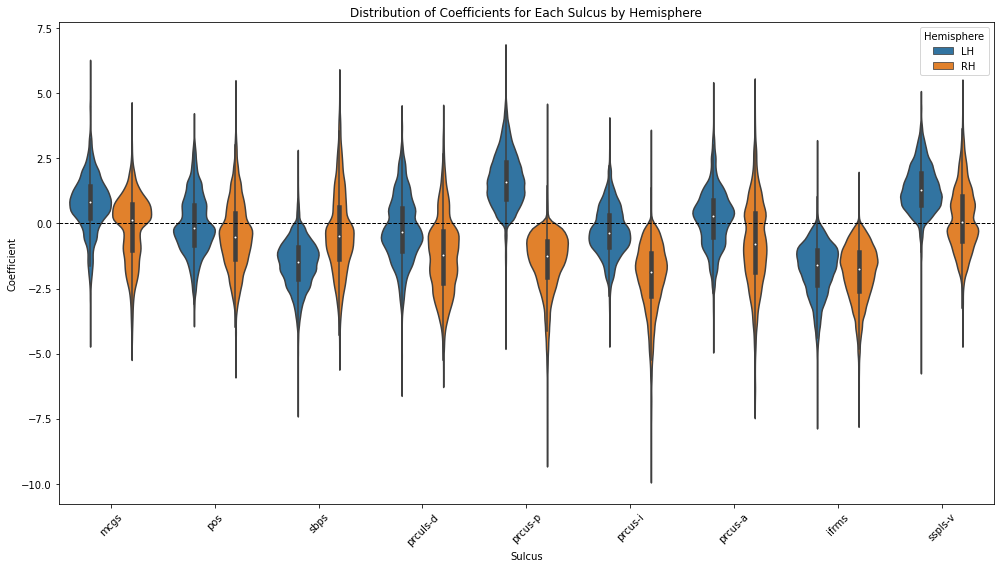

In [38]:
# Calculate average counts, percentages, medians, and confidence intervals
def calculate_stats(sulcus_counts, sulcus_coeffs, n_bootstrap, hemi):
    stats = {}
    if hemi == 'lh':
        df_len = len(lasso_LH_df)
    elif hemi == 'rh':
        df_len = len(lasso_RH_df)
    
    for sulc, count in sulcus_counts.items():
        coeffs = sulcus_coeffs[sulc]
        if coeffs:  # Avoid empty lists
            median = round(np.median(coeffs), 2)
            ci_lower, ci_upper = np.percentile(coeffs, [2.5, 97.5])
            ci_lower, ci_upper = round(ci_lower, 2), round(ci_upper, 2)
        else:
            median, ci_lower, ci_upper = 0, 0, 0

        stats[sulc] = {
            'Avg Count': round(count / n_bootstrap, 2),
            'Percentage': round((count / (df_len * n_bootstrap)) * 100, 2),
            'Median Coeff': median,
            '95% CI Lower': ci_lower,
            '95% CI Upper': ci_upper
        }
    return stats

sulcus_stats_RH = calculate_stats(sulcus_counts_RH, sulcus_coeffs_RH, n_bootstrap, 'rh')
sulcus_stats_LH = calculate_stats(sulcus_counts_LH, sulcus_coeffs_LH, n_bootstrap, 'lh')

# Convert stats to DataFrame for easier visualization
df_stats_RH = pd.DataFrame.from_dict(sulcus_stats_RH, orient='index')
df_stats_LH = pd.DataFrame.from_dict(sulcus_stats_LH, orient='index')

print("Final Sulcus Statistics for Right Hemisphere:")
print(df_stats_RH.sort_values('Percentage', ascending=False))
print()
print("Final Sulcus Statistics for Left Hemisphere:")
print(df_stats_LH.sort_values('Percentage', ascending=False))

# Combine coefficients for violin plot
df_coeffs_RH = pd.DataFrame([(sulc, coeff, 'RH') for sulc, coeffs in sulcus_coeffs_RH.items() for coeff in coeffs],
                            columns=['Sulcus', 'Coefficient', 'Hemisphere'])
df_coeffs_LH = pd.DataFrame([(sulc, coeff, 'LH') for sulc, coeffs in sulcus_coeffs_LH.items() for coeff in coeffs],
                            columns=['Sulcus', 'Coefficient', 'Hemisphere'])
df_coeffs = pd.concat([df_coeffs_RH, df_coeffs_LH], ignore_index=True)

#### Save out files with boostrapped results

In [39]:
df_stats_RH['Hemi'] = 'RH'
df_stats_LH['Hemi'] = 'LH'

df_sulc_stats = pd.concat([df_stats_RH, df_stats_LH]).reset_index()

cols = list(df_sulc_stats.columns)
cols.insert(1, cols.pop(cols.index('Hemi')))
df_sulc_stats = df_sulc_stats[cols]

df_sulc_stats.to_csv("lasso_bootstrap2000_stats_04272025.csv", index=False)

In [40]:
df_sulc_stats.sort_values('Median Coeff')

,index,Hemi,Avg Count,Percentage,Median Coeff,95% CI Lower,95% CI Upper
5,prcus-i,RH,17.16,61.28,-1.85,-5.27,-0.15
7,ifrms,RH,24.21,86.45,-1.76,-4.41,-0.22
16,ifrms,LH,25.40,72.58,-1.61,-4.04,-0.16
11,sbps,LH,18.87,53.90,-1.46,-3.48,0.05
4,prcus-p,RH,15.74,56.21,-1.26,-4.41,-0.03
3,prculs-d,RH,14.94,53.36,-1.23,-3.89,1.86
6,prcus-a,RH,9.78,34.94,-0.78,-4.00,2.45
1,pos,RH,13.61,48.59,-0.51,-2.91,2.26
2,sbps,RH,11.57,41.31,-0.47,-3.14,3.11
14,prcus-i,LH,14.06,40.18,-0.36,-2.12,1.57


In [42]:
df_coeffs.shape
df_coeffs

df_coeffs.to_csv("lasso_bootstrap2000_coeffs_04272025.csv", index=False)

### Summary of original model results (not the bootstrap)

In [53]:
# Print all results

### RH Results
print(f'''RH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_RH}
R^2 at optimal alpha:     {results_dict_rh['final_rr']}
RMSE at optimal alpha:     {results_dict_rh['final_rmse']}
Selected coefficients (median value from all cross-validation folds): 
{medians_RH}
      ''')
print()
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print()
print()
### LH Results
print(f'''LH LASSO Regression predicting {beh_var}: 

Optimal alpha value:      {alpha_dict_vf_LH}
R^2 at optimal alpha:     {results_dict_lh['final_rr']}
RMSE at optimal alpha:     {results_dict_lh['final_rmse']}
Selected coefficients (median value from all cross-validation folds): 
{medians_LH}
      ''')

RH LASSO Regression predicting CFMT: 

Optimal alpha value:      {'alpha': [0.255, 0.272, 0.291, 0.311, 0.332, 0.355, 0.38, 0.406, 0.434, 0.464, 0.496, 0.53, 0.567, 0.606, 0.648, 0.693, 0.741, 0.792, 0.846, 0.905, 0.967, 1.034, 1.105, 1.182, 1.263, 1.35, 1.444, 1.543, 1.65, 1.764, 1.885, 2.015, 2.154, 2.303, 2.462, 2.632, 2.814, 3.008, 3.215, 3.437, 3.675, 3.928, 4.199, 4.489]}
R^2 at optimal alpha:     -0.02046822142551563
RMSE at optimal alpha:     6.279945266661152
Selected coefficients (median value from all cross-validation folds): 
prcus-p   -0.26
prcus-i   -0.17
ifrms     -1.29
dtype: float64
      

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


LH LASSO Regression predicting CFMT: 

Optimal alpha value:      {'alpha': [0.255, 0.272, 0.291, 0.311, 0.332, 0.355, 0.38, 0.406, 0.434, 0.464, 0.496, 0.53, 0.567, 0.606, 0.648, 0.693, 0.741, 0.792, 0.846, 0.905, 0.967, 1.034, 1.105, 1.182, 1.263, 1.35, 1.444, 1.543, 1.65, 1.764, 1.885, 2.0

### AIC Comparison
First we calculate AIC scores from each of our models. Remember that with AIC, LOWER is better.

In [54]:
sulc_list = ['mcgs', 'pos', 'sbps', 'prculs-d', 'prcus-p', 'prcus-i', 'prcus-a', 'ifrms', 'sspls-v']

# Create dataframes for analysis
subset_NT_df = morph_df[['sub', 'hemi', 'group', 'CFMT'] + sulc_list].dropna()
NT_RH_df = subset_NT_df[(subset_NT_df['hemi'] == 'rh') & (subset_NT_df['group'] == 'Controls')] 

In [55]:
# Specify dataframes for LASSO
beh_var = 'CFMT'
lasso_RH_df = NT_RH_df

In [56]:
# Down-select to only the sulci that were selected by depth LASSO
rh_NT_depth_sulc = ['ifrms', 'prcus-p', 'prcus-i']

In [57]:
# run NT lasso regressions again to make sure we're dealing with NT LASSO and not anything else
results_dict_rh = lasso_fully_nested(lasso_RH_df[X_sulc], lasso_RH_df[beh_var], alpha_dict_vf_RH)

# NT linear regressions with all PMC sulci included as predictors
results_dict_rh_full_NT = linreg_cv(NT_RH_df[sulc_list], NT_RH_df[['CFMT']])

In [58]:
### get rmse for each model

## NT depth models
rh_lasso_rmse = results_dict_rh['final_rmse']
rh_all_rmse = results_dict_rh_full_NT['rmse']

print("RH LASSO rmse = {}".format(rh_lasso_rmse))
print("RH ALL   rmse = {}".format(rh_all_rmse))

RH LASSO rmse = 6.416385520940134
RH ALL   rmse = 7.4535122055885905


In [59]:
## AIC from RH Lasso model -- per Burnham and Anderson 2002 ##
# n = sample size (this is the number of hemispheres in the sample (check beginning of the output from the LASSO regression))
# number of params = (# of sulci) + intercept + error variance
n = NT_RH_df.shape[0]  # this is the number of hemispheres in the sample (check beginning of the output from the LASSO regression)
num_params = len(rh_NT_depth_sulc) + 2
AIC_rh_lasso = calculate_aic(n, rh_lasso_rmse, num_params)
print(AIC_rh_lasso)

## AIC from RH ALL model ##
# n = sample size of hemispheres, number of params = (# of sulci) + intercept
n = NT_RH_df.shape[0]
num_params = len(sulc_list) + 2  # number of sulci in the ALL model, plus intercept, plus error variance
AIC_rh_all = calculate_aic(n, rh_all_rmse, num_params)
print(AIC_rh_all)

116.82315027376497
150.98638006433634


In [60]:
# lower AIC is better. AIC delta>2 is an interpretable difference. delta>10 is substantial
# AIC is NOT appropriate for comparing models that used data with different sample sizes!

print("RH Models: ALL - LASSO")
delta_AIC_rh = AIC_rh_all - AIC_rh_lasso
print('''
RH_ALL AIC         = {}
RH_LASSO AIC       = {}
Delta                    = {}
'''.format(AIC_rh_all, AIC_rh_lasso, delta_AIC_rh))

RH Models: ALL - LASSO

RH_ALL AIC         = 150.98638006433634
RH_LASSO AIC       = 116.82315027376497
Delta                    = 34.16322979057138

